# Build a recommendation system to recommend products to  customers based on the their  previous ratings for other  product

Context

Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different
suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive
data sets and produces high-quality recommendations in real-time.


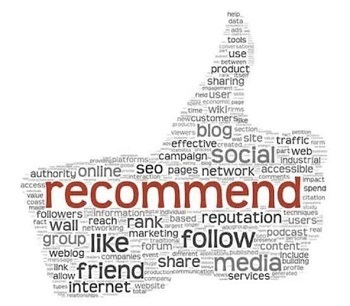


# Dataset:
https://drive.google.com/file/d/1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW/view?usp=sharing

In [141]:
## Import necessary python libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
import surprise
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from surprise import KNNWithMeans
from surprise import SVD
from surprise import Reader,Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate
from apyori import apriori
import scipy.sparse
import warnings; warnings.simplefilter('ignore')

# 1.Read and explore the given dataset

In [142]:
elec_df = pd.read_csv('ratings_Electronics.csv')
elec_df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [143]:
## Shape of data frame
rows, cols = elec_df.shape
print('Rows:', rows)
print('Columns:', cols)

Rows: 7824481
Columns: 4


# Rename column/add headers

In [144]:
elec_df.rename(columns={'AKM1MP6P0OYPR':'userId','0132793040':'productId','5.0':'Rating', '1365811200':'Timestamp'}, inplace=True)
elec_df.head()

,userId,productId,Rating,Timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [145]:
## Check datatypes
elec_df.dtypes

userId        object
productId     object
Rating       float64
Timestamp      int64
dtype: object

In [146]:
## Check for missing values
print('No of missing values across columns: \n',elec_df.isnull().sum())

No of missing values across columns: 
 userId       0
productId    0
Rating       0
Timestamp    0
dtype: int64



# Plot histograms

In [147]:
#sns.pairplot(elec_df,hue='Rating')

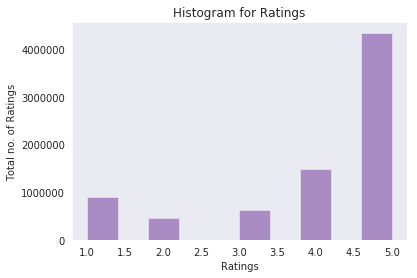

In [148]:
with sns.axes_style('dark'):
    sns.distplot(elec_df["Rating"],bins=10,color='indigo',label="Rating",kde=False)
    plt.title("Histogram for Ratings")
    plt.xlabel("Ratings")
    plt.ylabel("Total no. of Ratings")

Insight: Many users have given ratings in range of 4.5 and 5, then 4, 1,3

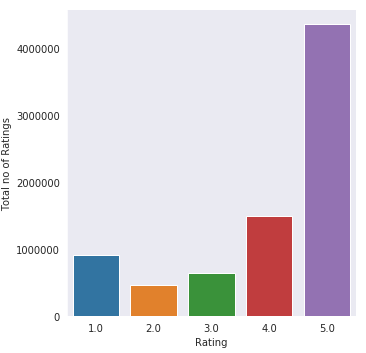

In [149]:
with sns.axes_style('dark'):
    g = sns.factorplot("Rating",data=elec_df,kind='count')
    g.set_ylabels('Total no of Ratings')

Text(0, 0.5, 'Frequency')

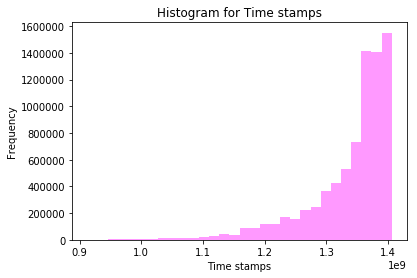

In [150]:
sns.distplot(elec_df["Timestamp"],bins=30,color='magenta',label="Time stamp",kde=False)
plt.title("Histogram for Time stamps")
plt.xlabel("Time stamps")
plt.ylabel("Frequency")

Descriptive Statistics for data characteristics

In [151]:
elec_df.describe().T


,count,mean,std,min,25%,50%,75%,max
Rating,7824481.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
Timestamp,7824481.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


In [152]:
## Finding min, max ratings
print('Min rating is:%d'%(elec_df['Rating'].min()))
print('Max rating is: %d' %(elec_df['Rating'].max()))

Min rating is:1
Max rating is: 5


In [153]:
print('No of unique users = %d' %(elec_df['userId'].nunique()))
print('No of unique items = %d' %(elec_df['productId'].nunique()))

No of unique users = 4201696
No of unique items = 476001


# 2. Take a subset of the dataset to make it less sparse/ denser (keep the users only who has given 50 or  more number of ratings)

In [154]:
elec_df.head()

,userId,productId,Rating,Timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [155]:
elec_df.groupby(["userId"])["Rating"].count().sort_values(ascending=False)[:20]

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
ARBKYIVNYWK3C     296
A22CW0ZHY3NJH8    292
A3EXWV8FNSSFL6    282
A38RMU1Y5TDP9     282
A3LGT6UZL99IW1    279
A2NOW4U7W3F7RI    277
A23GFTVIETX7DS    270
A3PD8JD9L4WEII    266
A17BUUBOU0598B    261
A3AYSYSLHU26U9    257
Name: Rating, dtype: int64

Insight: 

elec_sub= elec_df[elec_df.Rating.groupby(elec_df.userId).transform('count') >= 50] -->> Sparse dataframe/matrix with users who has given 50 or more ratings is throwing memory error at computing pearson baseline similarity matrix of fitting "KNNWithMeans" model step, hence going on with users has given 100 or more ratings.

In [157]:
elec_sub= elec_df[elec_df.Rating.groupby(elec_df.userId).transform('count') >= 250]
elec_sub

,userId,productId,Rating,Timestamp
2161,A5JLAU2ARJ0BO,1400532655,1.0,1291334400
3382,A3PD8JD9L4WEII,1400699169,5.0,1372204800
5194,A36K2N527TXXJN,9800359788,5.0,1367280000
5931,ADLVFFE4VBT8,9981719005,3.0,1238716800
7747,A680RUE1FDO8B,B000001OMI,5.0,1227744000
8731,A6FIAB28IS79,B00000J05A,3.0,985564800
10393,AWPODHOB4GFWL,B00000J1QS,4.0,1241740800
11017,A6FIAB28IS79,B00000J1UQ,5.0,1251763200
11035,A231WM2Z2JL0U3,B00000J1US,5.0,1010880000
12679,A6FIAB28IS79,B00000J4CY,3.0,1199404800


Total 7484 users gave 250 or more ratings.

In [158]:
print('Total no of records taken for CF= %d' %(len(elec_sub)))
print('No of unique users in sparse dataset= %d' %(elec_sub['userId'].nunique()))
print('No of unique items in sparse dataset= %d' %(elec_sub['productId'].nunique()))

Total no of records taken for CF= 7484
No of unique users in sparse dataset= 23
No of unique items in sparse dataset= 5841


# 3. Split the data randomly into train and test dataset

In [159]:
trainset, testset = train_test_split(elec_sub, test_size=0.3)

Also we can do train_test_split using surprise package. 
To do this in surprise library we should load data first into it's own data frame, using 'load_from_df'
then can be splitted into train and test sets used in item-to-item colloborative filtering approach. 

# 4. Build Popularity Recommendation Model

In [160]:
elec_sub.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B002NU5O8I    5.0
B003QRX4PC    5.0
B003ZK5NZY    5.0
B003ZG9T62    5.0
B003ZBZ64Q    5.0
Name: Rating, dtype: float64

In [161]:
pop_ratings_mean_count = pd.DataFrame(elec_sub.groupby('productId')['Rating'].mean())
pop_ratings_mean_count['rating_counts'] = pd.DataFrame(elec_sub.groupby('productId')['Rating'].count())

In [162]:
pop_ratings_mean_count.head(10)

,Rating,rating_counts
productId,,
1400532655,1.0,1
1400699169,5.0,1
9800359788,5.0,1
9981719005,3.0,1
B000001OMI,5.0,1
B00000J05A,3.0,1
B00000J1QS,4.0,1
B00000J1UQ,5.0,1
B00000J1US,5.0,1


In [163]:
trainset_grouped = trainset.groupby('productId').agg({'userId': 'count'}).reset_index()
trainset_grouped.rename(columns= {'userId': 'score'}, inplace=True)
trainset_grouped.head()

,productId,score
0,1400532655,1
1,1400699169,1
2,B000001OMI,1
3,B00000J1UQ,1
4,B00000J1US,1


In [164]:
trainset_sorted = trainset_grouped.sort_values(['score', 'productId'], ascending = [0,1])
trainset_sorted['Rank'] = trainset_sorted['score'].rank(ascending=0, method='first')

In [165]:
pop_recommendations = trainset_sorted[:10]
pop_recommendations

,productId,score,Rank
3262,B007OY5V68,10,1.0
2885,B0053R0WWG,9,2.0
3311,B0082E9K7U,8,3.0
2660,B004CLYEDC,7,4.0
3011,B005IMFX2K,7,5.0
4027,B00FSA8VQ2,7,6.0
3305,B00829THK0,6,7.0
3332,B0088CJT4U,6,8.0
3579,B00A1DJO12,6,9.0
3777,B00CMJZAOI,6,10.0


# 5.Build Collaborative Filtering model

In [166]:
# to load dataset from pandas df, we need `load_fromm_df` method in surprise lib
ratings_dict = {'userId': list(elec_sub.userId),
                'productId': list(elec_sub.productId),
                'Rating': list(elec_sub.Rating)}

In [167]:
df = pd.DataFrame(ratings_dict)

In [168]:
df.head()

,userId,productId,Rating
0,A5JLAU2ARJ0BO,1400532655,1.0
1,A3PD8JD9L4WEII,1400699169,5.0
2,A36K2N527TXXJN,9800359788,5.0
3,ADLVFFE4VBT8,9981719005,3.0
4,A680RUE1FDO8B,B000001OMI,5.0


In [172]:
# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(1.0, 5.0))

In [173]:
# The columns must correspond to user id, product id and ratings (in that order).
data = Dataset.load_from_df(df[['userId', 'productId', 'Rating']], reader)

Splitting Datasets into train and test 

In [174]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.3)

# Collaborative filtering

Item-Item collaborative filtering using KNN

In [175]:
# Creating KNN model
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})

In [176]:
# Fitting model with trainset
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [177]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [178]:
test_pred

[Prediction(uid='ARBKYIVNYWK3C', iid='B004L9M4AK', r_ui=5.0, est=4.328751431844215, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A38RMU1Y5TDP9', iid='B00110ENQ0', r_ui=5.0, est=4.328751431844215, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A680RUE1FDO8B', iid='B000IDCDZY', r_ui=3.0, est=4.328751431844215, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A17BUUBOU0598B', iid='B000XA2XJS', r_ui=3.0, est=4.328751431844215, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A38RMU1Y5TDP9', iid='B005T4ZBBK', r_ui=4.0, est=4.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A231WM2Z2JL0U3', iid='B00006LL8P', r_ui=5.0, est=4.328751431844215, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A22CW0ZHY3NJH8', iid='B005OA24PU', r_ui=5.0, est=4.328751431

SVD (Singular Valued Decomposition)

In [179]:
svd_alg = SVD()

In [180]:
svd_alg.fit(trainset)

In [181]:
svd_testpred =svd_alg.test(testset,verbose=False)

In [182]:
svd_testpred

[Prediction(uid='ARBKYIVNYWK3C', iid='B004L9M4AK', r_ui=5.0, est=4.398713947711425, details={'was_impossible': False}),
 Prediction(uid='A38RMU1Y5TDP9', iid='B00110ENQ0', r_ui=5.0, est=4.30082994246473, details={'was_impossible': False}),
 Prediction(uid='A680RUE1FDO8B', iid='B000IDCDZY', r_ui=3.0, est=4.45431770497646, details={'was_impossible': False}),
 Prediction(uid='A17BUUBOU0598B', iid='B000XA2XJS', r_ui=3.0, est=3.458038591768651, details={'was_impossible': False}),
 Prediction(uid='A38RMU1Y5TDP9', iid='B005T4ZBBK', r_ui=4.0, est=4.122149123214692, details={'was_impossible': False}),
 Prediction(uid='A231WM2Z2JL0U3', iid='B00006LL8P', r_ui=5.0, est=4.40443416650492, details={'was_impossible': False}),
 Prediction(uid='A22CW0ZHY3NJH8', iid='B005OA24PU', r_ui=5.0, est=4.292664485598526, details={'was_impossible': False}),
 Prediction(uid='A680RUE1FDO8B', iid='B001AALJ9U', r_ui=3.0, est=4.45431770497646, details={'was_impossible': False}),
 Prediction(uid='A2AY4YUOX2N1BQ', iid='B0

# 6.Evaluate both the models. ( Once the model is trained on  the training data, it can be used to compute the error  (RMSE) on predictions made on the test data.) 

RMSE for SVD

In [183]:
# get RMSE
print("SVD Model : Test Set")
accuracy.rmse(svd_testpred, verbose=True)

SVD Model : Test Set
RMSE: 0.9002


0.9002404360913777

RMSE for KNN

In [184]:
# get RMSE
print("KNN Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

KNN Model : Test Set
RMSE: 0.9676


0.967581678632943

# 7.Get top - K ( K = 5) recommendations. Since our goal is to  recommend new products for each user based on his/her  habits, we will recommend 5 new products.

Using SVD model

In [185]:
svd_testpred[:5]

[Prediction(uid='ARBKYIVNYWK3C', iid='B004L9M4AK', r_ui=5.0, est=4.398713947711425, details={'was_impossible': False}),
 Prediction(uid='A38RMU1Y5TDP9', iid='B00110ENQ0', r_ui=5.0, est=4.30082994246473, details={'was_impossible': False}),
 Prediction(uid='A680RUE1FDO8B', iid='B000IDCDZY', r_ui=3.0, est=4.45431770497646, details={'was_impossible': False}),
 Prediction(uid='A17BUUBOU0598B', iid='B000XA2XJS', r_ui=3.0, est=3.458038591768651, details={'was_impossible': False}),
 Prediction(uid='A38RMU1Y5TDP9', iid='B005T4ZBBK', r_ui=4.0, est=4.122149123214692, details={'was_impossible': False})]

Using KNN model

In [186]:
## Calculating KNNWithMeans for K=5
algo_k5 = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})

In [187]:
## Train algorithm on trainset
algo_k5.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [188]:
## Test algorithm against testset
test_pred5 = algo_k5.test(testset, verbose=False)

In [189]:
## Recommending 5 new products
test_pred5[:5]

[Prediction(uid='ARBKYIVNYWK3C', iid='B004L9M4AK', r_ui=5.0, est=4.328751431844215, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A38RMU1Y5TDP9', iid='B00110ENQ0', r_ui=5.0, est=4.328751431844215, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A680RUE1FDO8B', iid='B000IDCDZY', r_ui=3.0, est=4.328751431844215, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A17BUUBOU0598B', iid='B000XA2XJS', r_ui=3.0, est=4.328751431844215, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A38RMU1Y5TDP9', iid='B005T4ZBBK', r_ui=4.0, est=4.0, details={'actual_k': 0, 'was_impossible': False})]

In [190]:
# get RMSE
print("Item-based Model for 5 recommendations : Test Set")
accuracy.rmse(test_pred5, verbose=True)

Item-based Model for 5 recommendations : Test Set
RMSE: 0.9677


0.9676883916882201

Using Popularity based model

In [191]:
pop_ratings_mean_count[:5]

,Rating,rating_counts
productId,,
1400532655,1.0,1
1400699169,5.0,1
9800359788,5.0,1
9981719005,3.0,1
B000001OMI,5.0,1


In [192]:
def recommend(user_id):
    user_recommendations = pop_recommendations
    
    user_recommendations['userId'] = user_id
    cols = user_recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]
    
    return user_recommendations

In [193]:
find_recomm = ['A2XRMQA6PJ5ZJ8','A6FIAB28IS79','A680RUE1FDO8B','A22CW0ZHY3NJH8','A25C2M3QF9G7OQ'] # List of user choice
for i in find_recomm:
    print('Recommendation of user id : %s \n' %(i))
    print(recommend(i))
    print('\n')

Recommendation of user id : A2XRMQA6PJ5ZJ8 

              userId   productId  score  Rank
3262  A2XRMQA6PJ5ZJ8  B007OY5V68     10   1.0
2885  A2XRMQA6PJ5ZJ8  B0053R0WWG      9   2.0
3311  A2XRMQA6PJ5ZJ8  B0082E9K7U      8   3.0
2660  A2XRMQA6PJ5ZJ8  B004CLYEDC      7   4.0
3011  A2XRMQA6PJ5ZJ8  B005IMFX2K      7   5.0
4027  A2XRMQA6PJ5ZJ8  B00FSA8VQ2      7   6.0
3305  A2XRMQA6PJ5ZJ8  B00829THK0      6   7.0
3332  A2XRMQA6PJ5ZJ8  B0088CJT4U      6   8.0
3579  A2XRMQA6PJ5ZJ8  B00A1DJO12      6   9.0
3777  A2XRMQA6PJ5ZJ8  B00CMJZAOI      6  10.0


Recommendation of user id : A6FIAB28IS79 

            userId   productId  score  Rank
3262  A6FIAB28IS79  B007OY5V68     10   1.0
2885  A6FIAB28IS79  B0053R0WWG      9   2.0
3311  A6FIAB28IS79  B0082E9K7U      8   3.0
2660  A6FIAB28IS79  B004CLYEDC      7   4.0
3011  A6FIAB28IS79  B005IMFX2K      7   5.0
4027  A6FIAB28IS79  B00FSA8VQ2      7   6.0
3305  A6FIAB28IS79  B00829THK0      6   7.0
3332  A6FIAB28IS79  B0088CJT4U      6   8.0
3579  A6

Cross Validation based on RMSE

In [194]:
# Prepare all models
models = []
models.append(('KNNWithMeans', KNNWithMeans()))
models.append(('SVD', SVD()))
print(models)

[('KNNWithMeans', <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x00000207160A4390>), ('SVD', <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000002070CED8EB8>)]


In [195]:
# Evaluate each model in terms of 'rmse'
results = []
names = []
scoring = 'neg_mean_squared_error'

In [196]:
for name, model in models:
        kfold = KFold(n_splits=10, random_state=10)
        cv_results1 = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
        cv_results2 = cross_validate(svd_alg, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
        results.append(cv_results1)
        results.append(cv_results2)
        names.append(name)
        print(results)
        #msg = "%s: %f, (%f)" % (name, cv_results.mean(), cv_results.std())
        #print('\n {}'.format(msg))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0059  0.9837  0.9523  1.0090  0.9681  0.9838  0.0217  
MAE (testset)     0.7505  0.7302  0.7208  0.7528  0.7150  0.7339  0.0153  
Fit time          0.95    0.94    0.94    0.94    0.94    0.94    0.00    
Test time         0.09    0.08    0.08    0.09    0.

# 8.Summary of Insights

1.Popularity based recommendation system doesn’t give any personalizations as shown above which only gives the same list of recommended items/products to all users.

Hence Popularity Based Recommendation System is not good or suggestable for "Amazon" review dataset.

2.SVD and KNN are recommending same items to the users 'A22CW0ZHY3NJH8', 'A36K2N527TXXJN', 'A5JLAU2ARJ0BO', 'A23GFTVIETX7DS', 'A12DQZKRKTNF5E'.

3.In KMeans collaborative filtering we can see cold start problem, where as in SVD we doesn't have dealt with any cold start problem.

(Cold Start problem: 'was_impossible': True, 'reason': 'User and/or item is unkown.')